In [76]:
import os
import pandas as pd
import sys


def read_csv(filename="water_consumption.csv", delimiter=","):
    if not os.path.exists(filename):
        print(f"File '{filename}' does not exist.")
        sys.exit(1)
    
    df = pd.read_csv(filename, delimiter=delimiter)
    
    df['Consumption'] = df['Consumption'].str.replace(',', '.')
    
    df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
    df["Consumption"] = pd.to_numeric(df["Consumption"], errors="coerce")
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Day"] = pd.to_numeric(df["Day"], errors="coerce")


    if df.empty or len(df) == 1:
        raise ValueError("Empty file or file with only header.")
    return df

In [77]:
import numpy as np

def read_int(message="", max=np.inf, min=0):
    try:
        return int(input(message))
    except:
        print(f"Please enter a valid integer between {min} and {max}")
        return read_int(message, max, min)

In [78]:
import matplotlib as plt


# Graphically represent data through bar graphs
def plot_histogram(data, title, start_month, end_month, label="watter Consumption (m3)"):
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data.values, color="blue")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(label)
    plt.xticks(range(start_month, end_month + 1))
    plt.show()

In [79]:
import matplotlib as plt

def plot_park_histogram(data, title, park_name):
    plt.hist(data, bins=10, align="mid")
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title(f"{title} for Park {park_name} (10 bins)")
    plt.show()

    plt.hist(data, bins=100)
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title(f"{title} for Park {park_name} (100 bins)")
    plt.show()

In [80]:
from time import sleep


def barplot_monthly_water_consumption(df):
    # User inputs
    print("Available parks:")
    print(df["Park"].unique())
    sleep(0.1)
    park_id = input("Enter the park identification: ")

    # Filter the data based on the park identification
    park_data = df[df["Park"] == park_id]

    # Get the unique years in the park data
    years = park_data["Year"].unique()

    print("Available years:")
    print(years)
    sleep(0.1)

    year = read_int(message="Enter the year: ")
    start_month = read_int(message="Enter the start month (1-11): ", max=11, min=0)
    end_month = read_int(
        message=f"Enter the end month ({start_month}-12): ",
        max=12,
        min=start_month,
    )
    # Filter the data based on user inputs
    filtered_data = df[
        (df["Park"] == park_id)
        & (df["Year"] == year)
        & (df["Month"] >= start_month)
        & (df["Month"] <= end_month)
    ]

    # Calculate the total water consumption for each month
    choosen_park_data = filtered_data.groupby("Month")["Consumption"].sum()

    plot_histogram(
        choosen_park_data,
        f"Water Consumption in the Park {park_id}",
        start_month,
        end_month,
    )

In [81]:
import numpy as np
from matplotlib import pyplot as plt


def average_park_cost(df):
    parks = df["Park"].unique()
    print("Max number of parks to choose:", len(parks))
    sleep(0.1)
    choosen_parks = []
    num_of_parks = read_int(
        "Choose the number of parks you want to calculate the average water consumption: "
    )

    for _ in range(num_of_parks):
        inv_park = True
        while inv_park:
            print("Available parks: ")
            print(parks)
            sleep(0.1)
            park_id = input("Enter the park identification: ")
            if park_id.lower() in [park.lower() for park in parks]:
                choosen_parks.append([park for park in parks if park.lower() == park_id.lower()][0])
                inv_park = False
                parks = np.delete(parks, np.where([park.lower() == park_id.lower() for park in parks]))
            else:
                print("Invalid park identification. Try again.")

    # Filter the data based on user inputs
    filtered_data = df[df["Park"].isin(choosen_parks)]

    # Group the data by park, year, and month
    grouped_data = filtered_data.groupby(["Park", "Year", "Month"])

    # Calculate the total consumption for each month and apply the cost calculation
    monthly_costs = (
        grouped_data["Consumption"]
        .sum()
        .apply(lambda x: x * 0.7 if x <= 1000 else 1000 * 0.7 + (x - 1000) * 0.7 * 1.15)
    )

    # Calculate the average cost for each park
    average_costs = monthly_costs.groupby(level=0).mean()
    print(average_costs)

    # Plot the average costs
    plt.bar(average_costs.index, average_costs.values)
    plt.xlabel("Park")
    plt.ylabel("Average Monthly Water Cost")
    plt.title("Average Monthly Water Cost per Park")
    plt.show()

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew


def analyze_parks(df):
    print(df[0::5])

    # Filter out null values in the Consumption column
    filtered_df = df[df["Consumption"].notnull()]

    # Identify the park with the highest and lowest consumption
    highest_park = (
        filtered_df.groupby("Park")["Consumption"].mean().idxmax()
    )
    lowest_park = (
        filtered_df.groupby("Park")["Consumption"].mean().idxmin()
    )

    park_data = {}
    park_stats = {}

    # Calculate statistics for each park
    for park in [highest_park, lowest_park]:
        park_data[park] = filtered_df[filtered_df["Park"] == park][
            "Consumption"
        ]
        mean = park_data[park].mean()
        median = park_data[park].median()
        std = park_data[park].std()
        skewness = skew(park_data[park])

        park_stats[park] = {
            "Mean": mean,
            "Median": median,
            "Std": std,
            "Skewness": skewness,
        }

        print(f"Park {park} Statistics:")
        print(f"Mean: {mean}, Median: {median}, Std: {std}, Skewness: {skewness}")

        # Build frequency tables
        freq_table = pd.cut(park_data[park], 5).value_counts().sort_index()
        rel_freq_table = freq_table / len(park_data[park])

        print("Frequency Table:")
        print(freq_table)
        print("Relative Frequency Table:")
        print(rel_freq_table)
        # Plot frequency tables
        freq_table.plot(kind="bar", title=f"Frequency Table for Park {park}")
        plt.show()

        rel_freq_table.plot(
            kind="bar", title=f"Relative Frequency Table for Park {park}"
        )
        plt.show()
        # Check for outliers
        Q1 = park_data[park].quantile(0.25)
        Q3 = park_data[park].quantile(0.75)
        IQR = Q3 - Q1
        outliers = park_data[park][
            (park_data[park] < (Q1 - 1.5 * IQR)) | (park_data[park] > (Q3 + 1.5 * IQR))
        ]

        print("Outliers:")
        print(outliers)

        # Plot histograms
        plt.hist(park_data[park], bins=10, align="mid")
        plt.ylabel("Frequency")
        plt.xlabel("Consumption")
        plt.title(f"Park {park} Consumption Histogram (10 bins)")
        plt.show()

        plt.hist(park_data[park], bins=100)
        plt.ylabel("Frequency")
        plt.xlabel("Consumption")
        plt.title(f"Park {park} Consumption Histogram (100 bins)")
        plt.show()

    print("SUMMARY: ")

    # Plot summary histogram
    plt.hist(
        park_data[highest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {highest_park}",
        align="mid",
    )
    plt.hist(
        park_data[lowest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {lowest_park}",
        align="mid",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title("Park Consumption Histogram (10 bins)")
    plt.legend(loc="upper right")
    plt.show()

    plt.hist(
        park_data[highest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {highest_park}",
        align="mid",
    )
    plt.hist(
        park_data[lowest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {lowest_park}",
        align="mid",
    )

    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title("Park Consumption Histogram (100 bins)")
    plt.legend(loc="upper right")
    plt.show()

    for stat in ["Std", "Median", "Skewness"]:
        values = [park_stats[park][stat] for park in [highest_park, lowest_park]]
        plt.bar([highest_park, lowest_park], values)
        plt.title(f"{stat} by Park")
        plt.show()




In [83]:
#US10
import pandas as pd
import matplotlib.pyplot as plt


def pie_data(df):
    # Load the data

    # Count the occurrences of each piece of equipment
    equipment_counts = df["Equipment"].value_counts()

    # Plot the counts as a pie chart
    plt.pie(equipment_counts, labels=equipment_counts.index, autopct="%1.1f%%")
    plt.title("Equipment Usage")
    plt.show()

In [84]:
#US11
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
def analyze_user_data(df):
    # Identify the type of each variable
    print("Variable types:")
    print("Age range: Categorical (Ordinal)")
    print("Would you recommend the park to others: Categorical (Binary)")
    print("How many times do you visit the park per month: Numerical (Discrete)")

    # Calculate the proportion of users from each age group who would recommend the park to others
    recommendations = df[df["Would you recommend the park to others?"] == "Y"]["Age range"].value_counts() / df["Age range"].value_counts()
    print("\nProportion of users who would recommend the park to others:")
    print(recommendations)

    # Create a boxplot for each age group, regarding the monthly frequency of use of the park
    df.boxplot(column="How many times do you visit the park per month?", by="Age range")
    plt.title("Monthly frequency of park use by age group")
    plt.suptitle("")  # Suppress the automatic 'Boxplot grouped by' title
    plt.show()


--- Menu ---
1. Analyze Parks
2. Barplot Monthly Water consumption
3. Barplot Park Monthly Cost
4. Pie Chart Equipment Usage
5. Analyze the user data
6. Exit


Max number of parks to choose: 5
Available parks: 
['Oriental' 'ArcaAgua' 'Covelo' 'Cidade' 'SaoRoque']
Available parks: 
['ArcaAgua' 'Covelo' 'Cidade' 'SaoRoque']
Available parks: 
['Covelo' 'Cidade' 'SaoRoque']
Invalid park identification. Try again.
Available parks: 
['Covelo' 'Cidade' 'SaoRoque']
Available parks: 
['Cidade' 'SaoRoque']
Available parks: 
['SaoRoque']
Park
ArcaAgua     191.434727
Cidade      2739.639696
Covelo       333.149158
Oriental     759.310327
SaoRoque     325.173275
Name: Consumption, dtype: float64


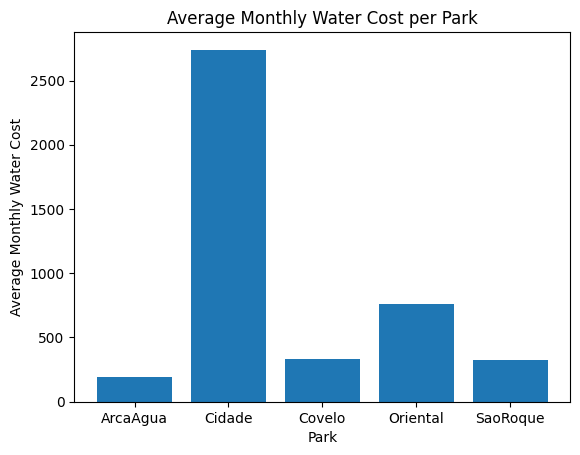


--- Menu ---
1. Analyze Parks
2. Barplot Monthly Water consumption
3. Barplot Park Monthly Cost
4. Pie Chart Equipment Usage
5. Analyze the user data
6. Exit
Exiting the application.


In [85]:
from time import sleep


def menu():
    while True:
        print("\n--- Menu ---")
        print("1. Analyze Parks")
        print("2. Barplot Monthly Water consumption")
        print("3. Barplot Park Monthly Cost")
        print("4. Pie Chart Equipment Usage")
        print("5. Analyze the user data")
        print("6. Exit")
        sleep(0.1)
        choice = input("Enter your choice: ")

        if choice == "1":
            df = read_csv(delimiter=";")
            analyze_parks(df)
        elif choice == "2":
            df = read_csv(delimiter=";")
            barplot_monthly_water_consumption(df)
        elif choice == "3":
            df = read_csv(delimiter=";")
            average_park_cost(df)
        elif choice == "4":
            df = read_csv(filename="EquipmentUsed.csv")
            pie_data(df)
        elif choice == "5":
            df = read_csv(filename="Inquiry.csv")
            analyze_user_data(df)
        elif choice == "6":
            # Exit the application
            print("Exiting the application.")
            break
        else:
            print("Invalid choice. Please choose a valid option.")


menu()